# 📉 Customer Churn Prediction with Explainable AI
**Author:** Allan Alex\
**Goal:** Predict customer churn in the Telecom industry and interpret the root causes using SHAP values.\
**Tech Stack:** Python, XGBoost, SHAP, Pandas, Scikit-Learn.

In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 1. Dimensions of the data
print(f"Dataset Shape: {df.shape}")
print("-" * 30)

# 2. Preview the data
print("First 5 rows:")
display(df.head())

# 3. Check data types
print("-" * 30)
print("Data Types:")
print(df.dtypes)

Dataset Shape: (7043, 21)
------------------------------
First 5 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


------------------------------
Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [11]:
# 1. Drop 'customerID' - it is unique for every person and has no predictive power
df.drop('customerID', axis=1, inplace=True)

# 2. Convert 'TotalCharges' from Object to Numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 3. Check for missing values (NaN) generated by the step above
print(f"Missing values in TotalCharges: {df['TotalCharges'].isnull().sum()}")

# 4. Drop the rows with missing values (it's only 11 rows out of 7000+)
df.dropna(inplace=True)

# 5. Convert 'Churn' (Yes/No) to Binary (1/0) so the model understands it
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("-" * 30)
print(f"New Shape: {df.shape}")  # Should be (7032, 20)
print(f"TotalCharges Type: {df['TotalCharges'].dtype}")

Missing values in TotalCharges: 11
------------------------------
New Shape: (7032, 20)
TotalCharges Type: float64


In [12]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

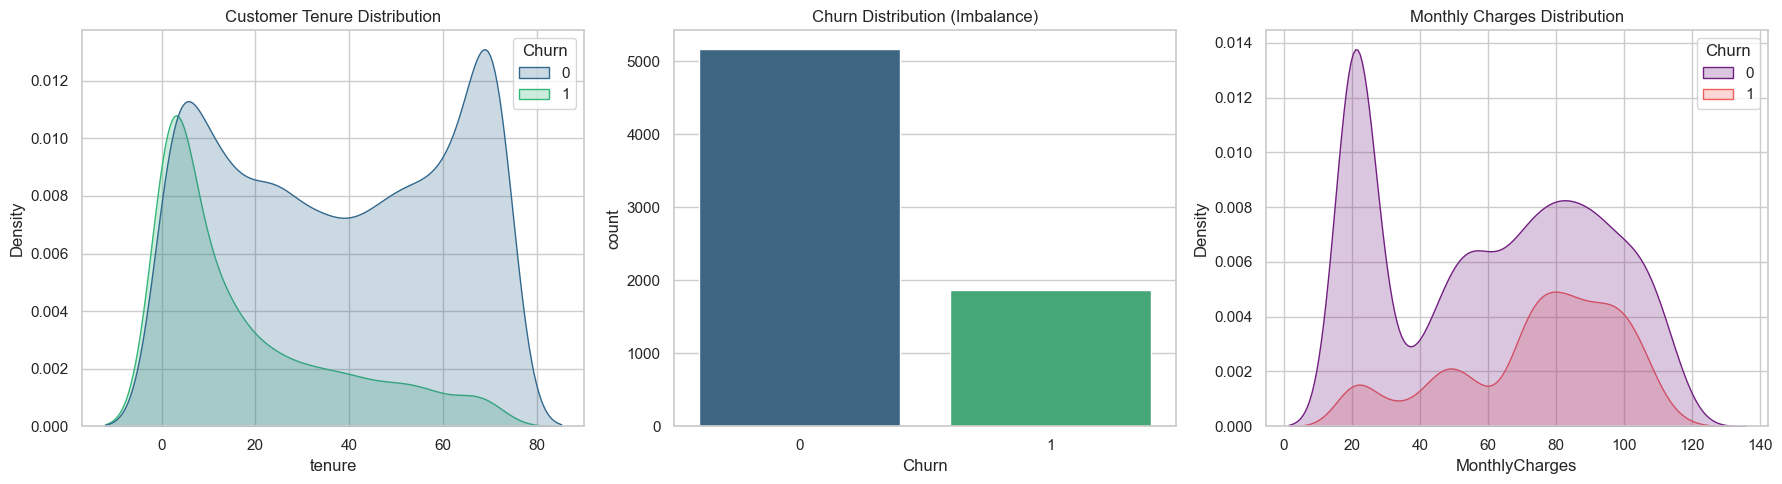

Churn Rate by Contract Type:
Contract
Month-to-month    42.709677
One year          11.277174
Two year           2.848665
Name: Churn, dtype: float64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set(style="whitegrid")

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: The Target Imbalance (Churn vs No Churn)
# Business Q: "How bad is the bleeding (losing money or customers rapidly)?"
# Are we losing a few customers (a scratch) or thousands of customers (a severe injury)?
sns.countplot(x='Churn', data=df, ax=axes[1], palette="viridis")
axes[1].set_title('Churn Distribution (Imbalance)')

# Plot 2: Tenure vs Churn
# Business Q: "Do loyal customers leave?"
sns.kdeplot(data=df, x="tenure", hue="Churn", fill=True, ax=axes[0], palette="viridis")
axes[0].set_title('Customer Tenure Distribution')

# Plot 3: Monthly Charges vs Churn
# Business Q: "Are we charging too much?"
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", fill=True, ax=axes[2], palette="magma")
axes[2].set_title('Monthly Charges Distribution')

plt.tight_layout()
plt.show()

# Quick text insight for Contract Type
print("Churn Rate by Contract Type:")
print(df.groupby('Contract')['Churn'].mean() * 100)

In [14]:
# 1. Get list of all categorical variables (excluding Churn which is already mapped)
cat_cols = [col for col in df.columns if df[col].dtype == 'object']

# 2. Perform One-Hot Encoding
# drop_first=True prevents "multicollinearity".
# Example: If we have 'Male' and 'Female', we only need 'Male' (1=Yes, 0=No). We don't need a 'Female' column.
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(f"Original Shape: {df.shape}")
print(f"New Encoded Shape: {df_encoded.shape}")

# Preview the new "Machine Ready" data
display(df_encoded.head())

Original Shape: (7032, 20)
New Encoded Shape: (7032, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [15]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Define Features (X) and Target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# 2. Split the data (80% for training, 20% for testing)
# stratify=y ensures we have the same ratio of Churners in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize and Train the XGBoost Model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 4. Make Predictions
y_pred = model.predict(X_test)

# 5. Evaluate the Model
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy Score: 77.83%
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.59      0.55      0.57       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407



In [16]:
import shap

def predict_wrapper(data):
    
    # 1. Rebuild the DataFrame
    df_temp = pd.DataFrame(data, columns=X_train.columns)
    
    # 2. FORCE conversion to Float (This fixes the 'Object' error)
    df_temp = df_temp.astype(float)
    
    # 3. Return predictions
    return model.predict_proba(df_temp)

print("Initializing SHAP...")

# 1. Use a small background sample
background_data = X_train.sample(n=20, random_state=42)

# 2. Initialize Explainer with the NEW wrapper
explainer = shap.KernelExplainer(predict_wrapper, background_data)

# 3. Calculate SHAP values for a small test sample
# We use 20 samples to keep it fast for the demo
X_test_sample = X_test.head(20)
shap_values = explainer.shap_values(X_test_sample)

print("✅ SHAP Values Calculated Successfully.")

Initializing SHAP...


  0%|          | 0/20 [00:00<?, ?it/s]

✅ SHAP Values Calculated Successfully.


📦 Detected Array format. Selecting Class 1...
Final Plotting Shape: (20, 30)


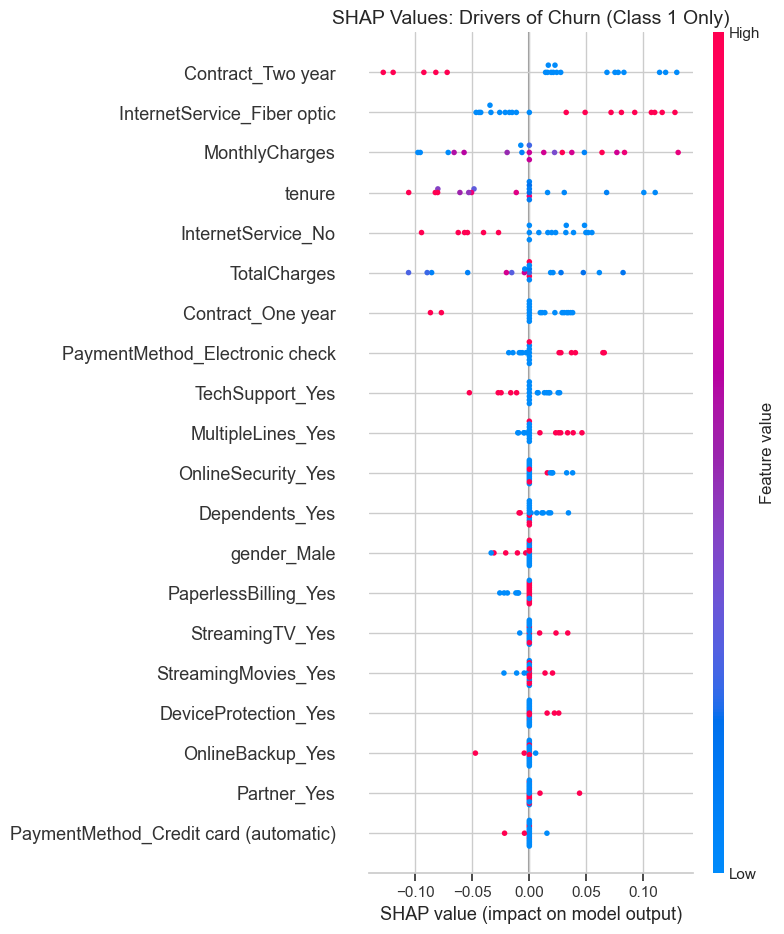

In [17]:
# Checking if shap_values is a List or an Array
if isinstance(shap_values, list):
    print(f"📦 Detected List format. Selecting Class 1...")
    vals_to_plot = shap_values[1]
else:
    print(f"📦 Detected Array format. Selecting Class 1...")
    # --- THE FIX: We specifically select index 1 (Churn) from the 3rd dimension ---
    # shape is (20, 30, 2) -> we want (20, 30) for Class 1
    vals_to_plot = shap_values[:, :, 1] 

# Verify the new shape (Should be just 2 dimensions now: 20, 30)
print(f"Final Plotting Shape: {np.shape(vals_to_plot)}")

# Plot
plt.figure(figsize=(10, 6))
plt.title('SHAP Values: Drivers of Churn (Class 1 Only)', fontsize=14)
shap.summary_plot(vals_to_plot, X_test_sample, plot_type="dot")

In [18]:
print("✅ Project: DONE. Thank you.")

✅ Project: DONE. Thank you.


---